# Example for the Plots
This notenbook illustrates how the plots work. Specifically, it shows how the `si_graph` and `network_plot` are connected and how the `stacked_bar_chart` works.

In [1]:
# import the necessary libraries

import shapiq

from hypershap.base.util.utils import setup_game
from hypershap.plots.plot_interactions import plot_si_graph, plot_stacked_bars

### Load a HPO Game
Load a game from disk to see what plots can be generated.
Here we load a `universal` hpo game from the `lcbench` benchmark with the `val_accuracy` metric.
1000 configurations were sampled in the benchmark.

Note that we set `only_load=True` to only load pre-computed games. If the game is not pre-computed, an error will be thrown. The typical workflow should be to pre-compute the games before experimenting.

In [2]:
# set up a game
hpo_game, hpo_game_name, parameter_names = setup_game(
    game_type="universal",  # "universal", "global", "local", "universal-local"
    benchmark_name="lcbench",  # name of the benchmark
    metric="val_accuracy",  # metric to be used for the game
    pre_compute=False,  # weather a game should be pre-computed or not if not present
    verbose=False,  # print out the progress of loading (this is only interesting for pre-computation)
    n_configs=1_000,  # number of configurations sampled in the benchmark
    instance_index=0,  # an index of the benchmark (not used in universal)
    only_load=True,  # only load pre-computed games, if not pre-computed throw an error
)

Loaded game from game_storage\universal_lcbench_metric=val_accuracy_n_configs=1000_random_state=42.npz.


### Setup shapiq Explainer / Exact Computer
We need to compute some values to plot and visualize. For this, we use the `ExactComputer` from the `shapiq` library. 
We will compute the following two interaction indices:

- 2-SII values: Two order Shapley interaction values.
- MI values: Moebius interaction values of order equal to the number of players in the game. The MI are the most expressive interactions as they decompose the game into all possible interactions between the players. Thus, a true additive decomposition is created.

In [3]:
# set up the computer
computer = shapiq.ExactComputer(n_players=hpo_game.n_players, game_fun=hpo_game)
two_sii_values = computer(index="k-SII", order=2)  # compute 2-SII values
mi_values = computer(index="Moebius", order=hpo_game.n_players)  # compute Moebius values

### Plot the Interactions with the Stacked Bar Plot
In the following, we are plotting the MI values with the `stacked_bar_chart` function.
The stacked bar chart shows globally how much interaction is present in a game. For a detailed description see this [paper](https://proceedings.mlr.press/v206/bordt23a).

In general, the plot shows for each parameter the size of its interactions and with what orders it is interacting. 
What happens here is that each interaction $S$ is getting projected down onto each feature. 
For example, a 3rd order interaction (blue color) $S = \{\text{`batch_size`}, \text{`max_dropout`}, \text{`max_units`}\}$ will be projected uniformly onto each individual player which is part of the interaction.
Suppose the value of the interaction is $\text{MI}(S) = 0.291$.
Then each parameter will get a uniform share of this interaction $\frac{\text{MI}(S)}{\vert S\vert} = \frac{0.291}{3} = 0.097$ associated with itself.
However, each individual parameter is part of multiple 3rd order interactions like $T = \{\text{`batch_size`}, \text{`learning_rate`}, \text{`weight_decay`}\}$ which can have different values like $\text{MI}(T) = -0.964$ and can even be negative.
To summarize this all into a single plot positive and negative parts are added together into a positive and a negative projection such that _each parameter_ can have a positive blue bar and a negative blue bar in the plot.
Only the first and n-order effect cannot be split into a positive or negative part, as there can only be one.

Value of interaction S: 0.2915496826171875$
Parameter Part: 0.0971832275390625
Value of interaction T: -0.9640960693359375$
Parameter Part: -0.3213653564453125


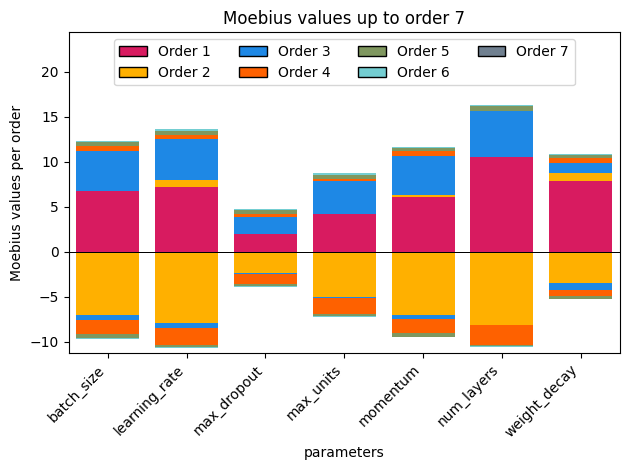

In [4]:
# plot the interactions
S = (0, 2, 3)
print(f"Value of interaction S: {mi_values[S]}$")
print(f"Parameter Part: {mi_values[S] / len(S)}")

T = (0, 1, 6)
print(f"Value of interaction T: {mi_values[T]}$")
print(f"Parameter Part: {mi_values[T] / len(T)}")

plot_stacked_bars(
    mi_values,  # the interaction values
    feature_names=parameter_names,  # the names of the features
)

### SI Graph Plot for Second Order Interactions
Next we will be plotting a si-graph and show how this relates to the network plots. 
The SI Graph can visualize a hypergraph of higher-order interactions.
However, if at most second order interactions are plotted, then it conveys the same information as the network plot.

##### Interpreting the Network Plot
The network plot can be read as follows. 
The larger the nodes and edges, the larger (in absolute terms) the interaction. 
If nodes/edge are red, the interaction is positive.
If nodes/edges are blue, the interaction is negative.

##### Interpreting the SI Graph
The SI Graph can be read as follows and is similar to the network plot but can depict hyperedges.
The larger the nodes, edges, and hyperedges, the larger (in absolute terms) the interaction.
If nodes/hyperedges are red, the interaction is positive.
If nodes/hyperedges are blue, the interaction is negative.
Unlike the network plot, in the SI Graph the node size is reflected as a larger border radius of the nodes and not the radius of the nodes.

(<Figure size 600x600 with 1 Axes>, <Axes: >)

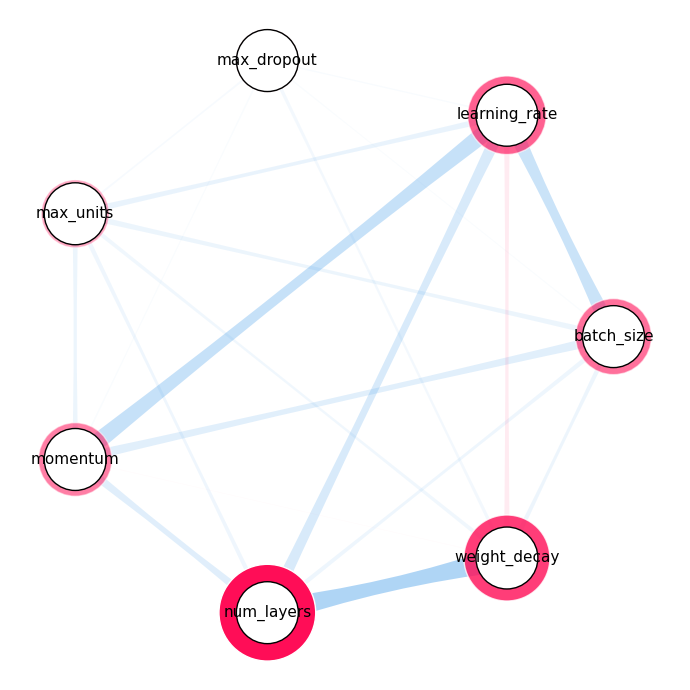

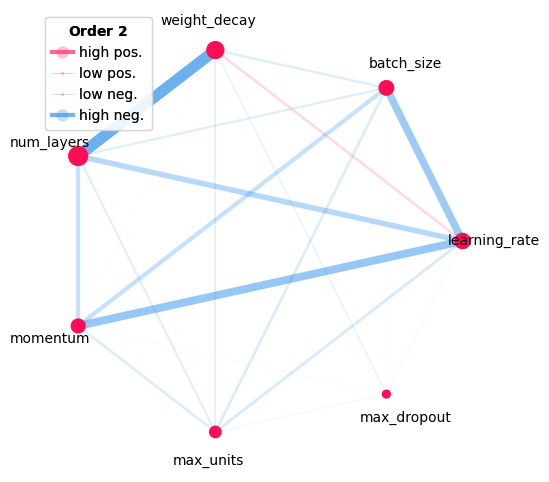

In [5]:
# plot si_graph for second order interactions
plot_si_graph(two_sii_values, parameter_names)

# plot network plot for second order interactions
two_sii_values.plot_network(feature_names=parameter_names)

### Visualizing Any-Order Interactions with the SI Graph
The SI Graph can be used to visualize higher-order ($ > 2$) interactions by illustrating these interactions as hyperedges connected with multiple nodes.

This can be seen when plotting the MIs.

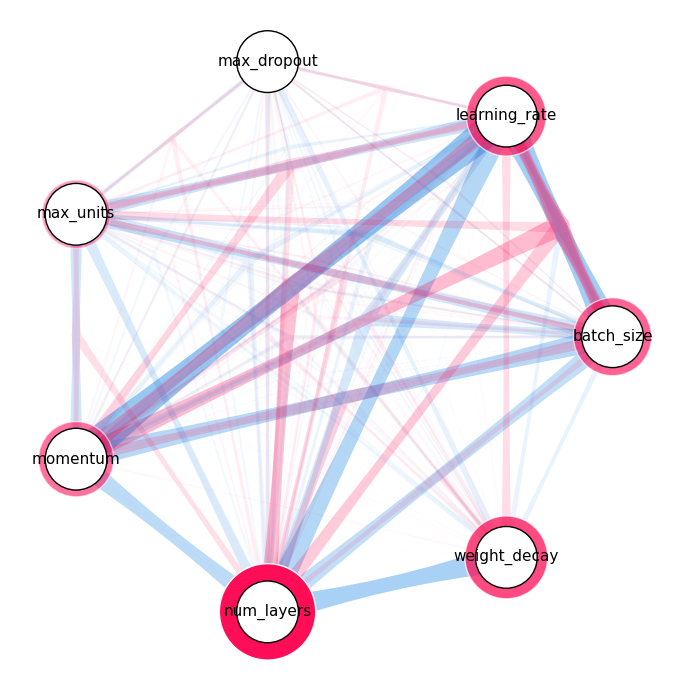

In [6]:
# plotting MIs with si graphs
plot_si_graph(mi_values, parameter_names)

This visualization could be a bit cluttered, so we can also only highlight specific orders in the plot with the optional `orders_to_plot: list[int]` parameter:

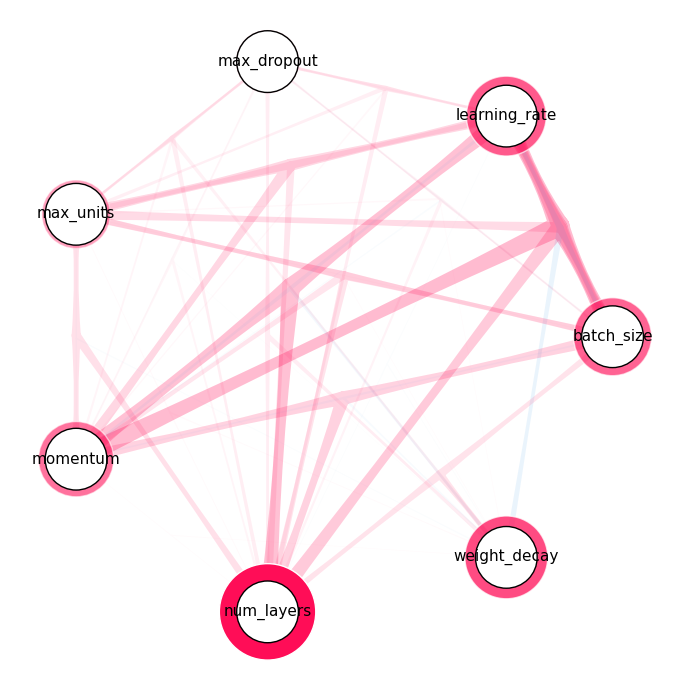

In [7]:
# plot an SI Graph with only order 1 and 3
plot_si_graph(mi_values, parameter_names, orders_to_plot=[1, 3])

**Note** that when limiting the orders they are just not plotted, the scaling and layouting still takes place with all interactions passed to the plotting function.

You can also scale the plot as you want by providing the optional `min_max_interactions: tuple[float, float]` parameter to any size.
In the following we will rescale the plot by reducing the size with some external max/min values:

Min/Max values: -4.8748321533203125 10.529953002929688


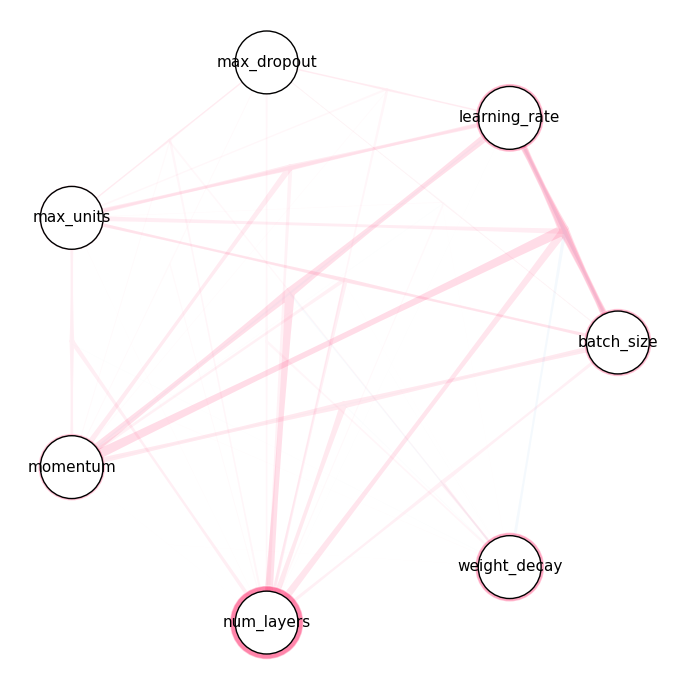

In [8]:
# get the min/max values from the numpy array of the InteractionValues
max_value = max(mi_values.values)
min_value = min(mi_values.values)
print(f"Min/Max values: {min_value} {max_value}")

# make min/max double in both directions
new_max = max_value * 2
new_min = min_value * 2

# plot si graph with new scales
plot_si_graph(
    mi_values, parameter_names, orders_to_plot=[1, 3], min_max_interactions=(new_min, new_max)
)